In [1]:
import qif
import numpy as np
import pandas as pd

from causalgraphicalmodels import StructuralCausalModel, CausalGraphicalModel
from tqdm.notebook import tqdm
from scipy.stats import entropy
from multiprocessing import Pool

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

## Channels

In [2]:
# Support functions
def bernoulli(p, size=None):
    """p = P(x=1)"""
    return np.random.binomial(n=1, p=p, size=size)


def _z_channel(x, flip):
    if x == 0:
        return 0
    else:
        return bernoulli(1-flip)
    

def _direct_channel(x):
    return x


def _symmetric_channel(x, flip):
    if x == 0:
        return bernoulli(flip)
    else:
        return bernoulli(1 - flip)
    
    
def _xor_channel(x1, x2):
    if x1 == x2:
        return bernoulli(0)
    else:
        return bernoulli(1)
    

def _pxor_channel(x1, x2, flip):
    if x1 == x2:
        return bernoulli(flip)
    else:
        return bernoulli(1 - flip)
    

def _and_channel(x1, x2):
    if x1 == x2 == 1:
        return bernoulli(1)
    else:
        return bernoulli(0)
    

def _pand_channel(x1, x2, flip):
    if x1 == x2 == 1:
        return bernoulli(1 - flip)
    else:
        return bernoulli(flip)
    

def _or_channel(x1, x2):
    if x1 == x2 == 0:
        return bernoulli(0)
    else:
        return bernoulli(1)
    

def _por_channel(x1, x2, flip):
    if x1 == x2 == 0:
        return bernoulli(flip)
    else:
        return bernoulli(1 - flip)
    
    
def joint_distribution(df, x, y):
    joint_dist = df.groupby([x, y]).size().unstack()
    joint_dist.columns = joint_dist.columns.get_level_values(0)
    joint_dist = joint_dist.div(joint_dist.sum().sum())
    return joint_dist.fillna(0)

In [3]:
# Graph function
def one_variable_channel(x, flip=0.5, name='z'):
    if name == 'z':
        return _z_channel(x, flip)
    elif name == 'direct':
        return _direct_channel(x)
    elif name == 'symmetric':
        return _symmetric_channel(x, flip)
    else:
        raise NameError('Function not valid')
    
    
def two_variables_channel(x1, x2, flip=0.5, name='xor'):
    if name == 'xor':
        return _xor_channel(x1, x2)
    elif name == 'pxor':
        return _pxor_channel(x1, x2, flip)
    elif name == 'and':
        return _and_channel(x1, x2)
    elif name == 'pand':
        return _pand_channel(x1, x2, flip)
    elif name == 'or':
        return _or_channel(x1, x2)
    elif name == 'por':
        return _por_channel(x1, x2, flip)
    else:
        raise NameError('Function not valid')

In [4]:
# Entropy functions
def guessing_entropy(l):
    """ Return the Shannon entropy of random variable with probability vector l"""
    tmp = l.sort_values(ascending=False)
    return sum([p*i for (i,p) in enumerate(l)]) + 1


def shannon_entropy(l):
    return entropy(l, base=2)


def joint_shannon_entropy(joint):
    return shannon_entropy(joint.values.flatten())


def conditional_shannon_entropy(joint, axis=1):
    X = joint.sum(axis=axis)
    Y_given_X = joint.div(X, axis=1)
    ent = 0
    for x in X.index:
        if axis == 1:
            tmp = Y_given_X.loc[x]
        else:
            tmp = Y_given_X[x]
        ent += X.loc[x] * entropy(tmp, base=2)   
    return ent


def mutual_information(joint, axis=0):
    Y = joint.sum(axis=axis)
    return shannon_entropy(Y) - conditional_shannon_entropy(joint, axis=1-axis)

In [5]:
# Compute attributes
def test_suite(df):
    data = {}
    joint = joint_distribution(df, x='X', y='Y')
    data['shannon_entropy_X'] = shannon_entropy(joint.sum(axis=1))
    data['shannon_entropy_Y'] = shannon_entropy(joint.sum(axis=0))
    data['joint_shannon_entropy'] = joint_shannon_entropy(joint)
    data['conditional_shannon_entropy_X|Y'] = conditional_shannon_entropy(joint, axis=0)
    data['conditional_shannon_entropy_Y|X'] = conditional_shannon_entropy(joint, axis=1)
    data['mutual_information'] = mutual_information(joint, axis=0)
    data['guessing_entropy_X'] = guessing_entropy(joint.sum(axis=1))
    data['guessing_entropy_Y'] = guessing_entropy(joint.sum(axis=0))
    
    bayes = qif.BayesLeakage(df)
    data['mult_avg_dir_flow'], data['mult_avg_rev_flow'] = bayes.compute_flows(x='X', y='Y')
    data['mult_max_dir_flow'], data['mult_max_rev_flow'] = bayes.compute_flows(x='X', y='Y', vulnerability_type='max')
    data['addt_avg_dir_flow'], data['addt_avg_rev_flow'] = bayes.compute_flows(x='X', y='Y', leakage_type='additive')
    data['addt_max_dir_flow'], data['addt_max_rev_flow'] = bayes.compute_flows(x='X', y='Y', leakage_type='additive', vulnerability_type='max')
    return data

In [6]:
# Validation functions
def plot_flows(df):
    plt.figure(figsize=(10, 10))

    groups = df.groupby("label")
    for name, group in groups:
        plt.plot(group['reverse_flow'], group['direct_flow'], marker="o", linestyle="", label=name, alpha=0.5)
    plt.plot([0.95, 3], [0.95, 3], color='black', linewidth=0.5, linestyle='dashed')
    plt.xlabel("Reverse Flow", fontsize=14)
    plt.ylabel("Direct Flow", fontsize=14)
    plt.xlim([0.95, 2])
    plt.ylim([0.95, 2])
    plt.legend(fontsize=14)
    plt.show()


def run_experiment(graph, n_samples=10000, n_runs=1000):
    flows = []
    for i in range(n_runs):
        data = graph.sample(n_samples)
        bayes_leakage = qif.BayesLeakage(data)
        avg_dir_flow, avg_rev_flow = bayes_leakage.compute_flows(x='X', y='Y')
        flows.append([avg_dir_flow, avg_rev_flow])
        
    return flows

In [7]:
# Setup
one_var_list = ['z', 'direct', 'symmetric']
two_var_list = ['xor', 'pxor', 'and', 'pand', 'or', 'por']
p = [0, 0.25, 0.5, 0.75, 1]

# Aliases
choice = np.random.choice

## SCMs

### Basic

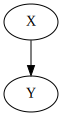

In [8]:
basic_causal = StructuralCausalModel({
    "X": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "Y": lambda X, n_samples: np.array(list(map(one_variable_channel, X, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
})

basic_causal.cgm.draw()

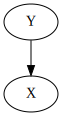

In [9]:
basic_anticausal = StructuralCausalModel({
    "Y": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "X": lambda Y, n_samples: np.array(list(map(one_variable_channel, Y, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
})

basic_anticausal.cgm.draw()

### Chain

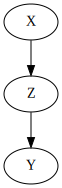

In [10]:
chain_causal = StructuralCausalModel({
    "X": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "Z": lambda X, n_samples: np.array(list(map(one_variable_channel, X, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
    "Y": lambda Z, n_samples: np.array(list(map(one_variable_channel, Z, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
})

chain_causal.cgm.draw()

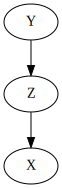

In [11]:
chain_anticausal = StructuralCausalModel({
    "Y": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "Z": lambda Y, n_samples: np.array(list(map(one_variable_channel, Y, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
    "X": lambda Z, n_samples: np.array(list(map(one_variable_channel, Z, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
})

chain_anticausal.cgm.draw()

### Cofounder

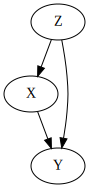

In [12]:
cofounder_causal = StructuralCausalModel({
    "Z": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "X": lambda Z, n_samples: np.array(list(map(one_variable_channel, Z, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
    "Y": lambda X, Z, n_samples: np.array(list(map(two_variables_channel, X, Z, np.array([choice(p)] * n_samples), np.array([choice(two_var_list)] * n_samples)))),
})

cofounder_causal.cgm.draw()

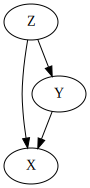

In [13]:
cofounder_anticausal = StructuralCausalModel({
    "Z": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "Y": lambda Z, n_samples: np.array(list(map(one_variable_channel, Z, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
    "X": lambda Y, Z, n_samples: np.array(list(map(two_variables_channel, Y, Z, np.array([choice(p)] * n_samples), np.array([choice(two_var_list)] * n_samples)))),
})

cofounder_anticausal.cgm.draw()

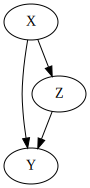

In [14]:
cofounder_causal2 = StructuralCausalModel({
    "X": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "Z": lambda X, n_samples: np.array(list(map(one_variable_channel, X, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
    "Y": lambda X, Z, n_samples: np.array(list(map(two_variables_channel, X, Z, np.array([choice(p)] * n_samples), np.array([choice(two_var_list)] * n_samples)))),
})

cofounder_causal2.cgm.draw()

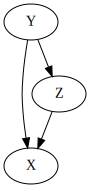

In [15]:
cofounder_anticausal2 = StructuralCausalModel({
    "Y": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "Z": lambda Y, n_samples: np.array(list(map(one_variable_channel, Y, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
    "X": lambda Y, Z, n_samples: np.array(list(map(two_variables_channel, Y, Z, np.array([choice(p)] * n_samples), np.array([choice(two_var_list)] * n_samples)))),
})

cofounder_anticausal2.cgm.draw()

### Collider

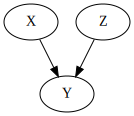

In [16]:
collider_causal = StructuralCausalModel({
    "X": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "Z": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "Y": lambda X, Z, n_samples: np.array(list(map(two_variables_channel, X, Z, np.array([choice(p)] * n_samples), np.array([choice(two_var_list)] * n_samples)))),
})

collider_causal.cgm.draw()

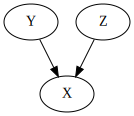

In [17]:
collider_anticausal = StructuralCausalModel({
    "Y": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "Z": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "X": lambda Y, Z, n_samples: np.array(list(map(two_variables_channel, Y, Z, np.array([choice(p)] * n_samples), np.array([choice(two_var_list)] * n_samples)))),
})

collider_anticausal.cgm.draw()

### Frontdoor

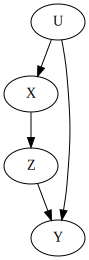

In [18]:
frontdoor_causal = StructuralCausalModel({
    "U": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "X": lambda U, n_samples: np.array(list(map(one_variable_channel, U, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
    "Z": lambda X, n_samples: np.array(list(map(one_variable_channel, X, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
    "Y": lambda U, Z, n_samples: np.array(list(map(two_variables_channel, U, Z, np.array([choice(p)] * n_samples), np.array([choice(two_var_list)] * n_samples)))),
})

frontdoor_causal.cgm.draw()

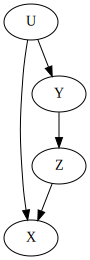

In [19]:
frontdoor_anticausal = StructuralCausalModel({
    "U": lambda    n_samples: np.random.binomial(n=1, p=choice(p), size=n_samples),
    "Y": lambda U, n_samples: np.array(list(map(one_variable_channel, U, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
    "Z": lambda Y, n_samples: np.array(list(map(one_variable_channel, Y, np.array([choice(p)] * n_samples), np.array([choice(one_var_list)] * n_samples)))),
    "X": lambda U, Z, n_samples: np.array(list(map(two_variables_channel, U, Z, np.array([choice(p)] * n_samples), np.array([choice(two_var_list)] * n_samples)))),
})

frontdoor_anticausal.cgm.draw()

## Experiment

In [20]:
scms = {
    'basic_causal':basic_causal,
    'basic_anticausal':basic_anticausal,
    'chain_causal':chain_causal,
    'chain_anticausal':chain_anticausal,
    'cofounder_causal':cofounder_causal,
    'cofounder_causal2':cofounder_causal2,
    'cofounder_anticausal':cofounder_anticausal,
    'cofounder_anticausal2':cofounder_anticausal2,
    'collider_causal':collider_causal,
    'collider_anticausal':collider_anticausal,
    'frontdoor_causal':frontdoor_causal,
    'frontdoor_anticausal':frontdoor_anticausal
}

def sample_base(scm_name, n=1000):
    scms = {
        'basic_causal':basic_causal,
        'basic_anticausal':basic_anticausal,
        'chain_causal':chain_causal,
        'chain_anticausal':chain_anticausal,
        'cofounder_causal':cofounder_causal,
        'cofounder_causal2':cofounder_causal2,
        'cofounder_anticausal':cofounder_anticausal,
        'cofounder_anticausal2':cofounder_anticausal2,
        'collider_causal':collider_causal,
        'collider_anticausal':collider_anticausal,
        'frontdoor_causal':frontdoor_causal,
        'frontdoor_anticausal':frontdoor_anticausal
    }
    
    df = scms[scm_name].sample(n)
    return df


def run_test(scm_name):
    df = sample_base(scm_name)
    flows = test_suite(df)
    flows['scm'] = scm_name
    return flows

In [21]:
n_runs = 100000
idx = choice(list(scms.keys()), size=n_runs)

parallelized_test = Pool()
data = parallelized_test.map(run_test, idx)

In [22]:
df = pd.DataFrame(data)

In [24]:
df.to_csv("sample_flows_100k.csv", index=False)

### Debug

In [62]:
flows_causal = run_experiment(basic_causal, n_samples=1000, n_runs=1000)
df_causal = pd.DataFrame(flows_causal, columns=['direct_flow', 'reverse_flow'])
df_causal['label'] = 'Causal'

flows_anticausal = run_experiment(basic_anticausal, n_samples=1000, n_runs=1000)
df_anticausal = pd.DataFrame(flows_anticausal, columns=['direct_flow', 'reverse_flow'])
df_anticausal['label'] = 'Anti-Causal'

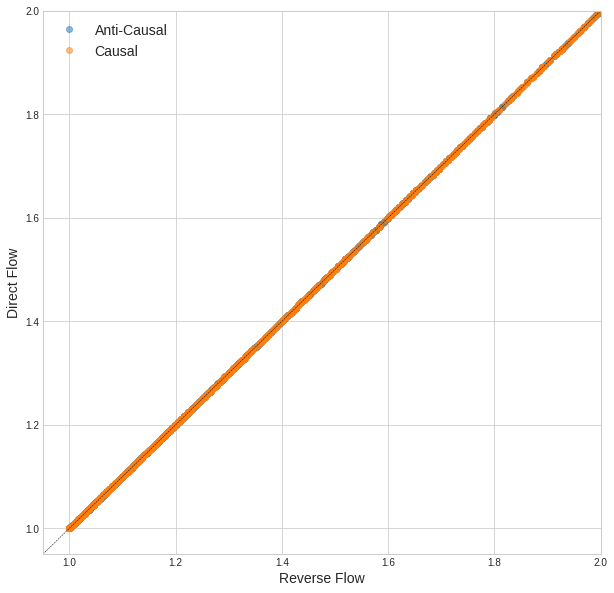

In [63]:
df = pd.concat([df_causal, df_anticausal])
plot_flows(df)

In [64]:
print("Causal")
print("Direct > Reverse:", df.query("direct_flow > reverse_flow and label == 'Causal'").shape[0]/df.shape[0]*2)
print("Direct = Reverse:", df.query("direct_flow == reverse_flow and label == 'Causal'").shape[0]/df.shape[0]*2)
print("Direct < Reverse:", df.query("direct_flow < reverse_flow and label == 'Causal'").shape[0]/df.shape[0]*2)
print("____________________________________")
print("Anti-Causal")
print("Direct > Reverse:", df.query("direct_flow > reverse_flow and label == 'Anti-Causal'").shape[0]/df.shape[0]*2)
print("Direct = Reverse:", df.query("direct_flow == reverse_flow and label == 'Anti-Causal'").shape[0]/df.shape[0]*2)
print("Direct < Reverse:", df.query("direct_flow < reverse_flow and label == 'Anti-Causal'").shape[0]/df.shape[0]*2)

Causal
Direct > Reverse: 0.0
Direct = Reverse: 1.0
Direct < Reverse: 0.0
____________________________________
Anti-Causal
Direct > Reverse: 0.0
Direct = Reverse: 1.0
Direct < Reverse: 0.0
